In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(p,q,r,s,t,u):
    stat = 0
    if p+q != 0:
        stat += (p-q)**2/(p+q)
    if r+s != 0:
        stat += (r-s)**2/(r+s)
    if t+u != 0:
        stat += (t-u)**2/(t+u)
    return stat

In [3]:
def LS(p,q,r,s,t,u): #local sensitivity
    stat = chi2(p,q,r,s,t,u); v = np.zeros(0)
    M = chi2(p,q,r,s,t,u); m = chi2(p,q,r,s,t,u)
    if p >= 1:
        v = [chi2(p-1,q+1,r,s,t,u), chi2(p-1,q,r+1,s,t,u), chi2(p-1,q,r,s+1,t,u), 
             chi2(p-1,q,r,s,t+1,u), chi2(p-1,q,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if q >= 1:
        v = [chi2(p+1,q-1,r,s,t,u), chi2(p,q-1,r+1,s,t,u), chi2(p,q-1,r,s+1,t,u), 
             chi2(p,q-1,r,s,t+1,u), chi2(p,q-1,r,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if r >= 1:
        v = [chi2(p+1,q,r-1,s,t,u), chi2(p,q+1,r-1,s,t,u), chi2(p,q,r-1,s+1,t,u), 
             chi2(p,q,r-1,s,t+1,u), chi2(p,q,r-1,s,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if s >= 1:
        v = [chi2(p+1,q,r,s-1,t,u), chi2(p,q+1,r,s-1,t,u), chi2(p,q,r+1,s-1,t,u), 
             chi2(p,q,r,s-1,t+1,u), chi2(p,q,r,s-1,t,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if t >= 1:
        v = [chi2(p+1,q,r,s,t-1,u), chi2(p,q+1,r,s,t-1,u), chi2(p,q,r+1,s,t-1,u), 
             chi2(p,q,r,s+1,t-1,u), chi2(p,q,r,s,t-1,u+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if u >= 1:
        v = [chi2(p+1,q,r,s,t,u-1), chi2(p,q+1,r,s,t,u-1), chi2(p,q,r+1,s,t,u-1), 
             chi2(p,q,r,s+1,t,u-1), chi2(p,q,r,s,t+1,u-1)]
        M = max([max(v),M])
        m = min([min(v),m])
    
    return max([M-stat, stat-m])

In [4]:
def LS_all(n):
    ls = np.zeros((n+1,n+1,n+1,n+1,n+1))
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+q >= r+s and r+s >= t+u and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = LS(p,q,r,s,t,u)
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+q >= r+s and r+s >= t+u and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[q][p][s][r][u]
                        elif p+q >= t+u and t+u >= r+s and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = ls[p][q][t][u][r]
                        elif p+q >= t+u and t+u >= r+s and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[q][p][u][t][s]
                        elif r+s >= p+q and p+q >= t+u and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = ls[r][s][p][q][t]
                        elif r+s >= p+q and p+q >= t+u and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[s][r][q][p][u]
                        elif r+s >= t+u and t+u >= p+q and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = ls[r][s][t][u][p]
                        elif r+s >= t+u and t+u >= p+q and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[s][r][u][t][q]
                        elif t+u >= p+q and p+q >= r+s and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = ls[t][u][p][q][r]
                        elif t+u >= p+q and p+q >= r+s and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[u][t][q][p][s]
                        elif t+u >= r+s and r+s >= p+q and p+r+t >= q+s+u:
                            ls[p][q][r][s][t] = ls[t][u][r][s][p]
                        elif t+u >= r+s and r+s >= p+q and p+r+t < q+s+u:
                            ls[p][q][r][s][t] = ls[u][t][s][r][q]
    return ls

In [5]:
def S(n): #max_{x,y}(LS(x)/LS(y))
    ls = LS_all(n)
    v = 1
    for p in range(n+1):
        for q in range(n-p+1):
            for r in range(n-p-q+1):
                for s in range(n-p-q-r+1):
                    for t in range(n-p-q-r-s+1):
                        u = n-p-q-r-s-t
                        if p+q >= r+s and r+s >= t+u and p+r+t >= q+s+u:
                            ss = ls[p][q][r][s][t]
                            if p >= 1:
                                ss = max([ls[p-1][q+1][r][s][t], ls[p-1][q][r+1][s][t], ls[p-1][q][r][s+1][t],
                                          ls[p-1][q][r][s][t+1], ls[p-1][q][r][s][t], ss])
                            if q >= 1:
                                ss = max([ls[p+1][q-1][r][s][t], ls[p][q-1][r+1][s][t], ls[p][q][r][s+1][t],
                                          ls[p][q-1][r][s][t+1], ls[p][q-1][r][s][t], ss])
                            if r >= 1:
                                ss = max([ls[p+1][q][r-1][s][t], ls[p][q+1][r-1][s][t], ls[p][q][r-1][s+1][t],
                                          ls[p][q][r-1][s][t+1], ls[p][q][r-1][s][t], ss])
                            if s >= 1:
                                ss = max([ls[p+1][q][r][s-1][t], ls[p][q+1][r][s-1][t], ls[p][q][r+1][s-1][t],
                                          ls[p][q][r][s-1][t+1], ls[p][q][r][s-1][t], ss])
                            if t >= 1:
                                ss = max([ls[p+1][q][r][s][t-1], ls[p][q+1][r][s][t-1], ls[p][q][r+1][s][t-1],
                                          ls[p][q][r][s+1][t-1], ls[p][q][r][s][t-1], ss])
                            if u >= 1:
                                ss = max([ls[p+1][q][r][s][t], ls[p][q+1][r][s][t], ls[p][q][r+1][s][t],
                                          ls[p][q][r][s+1][t], ls[p][q][r][s][t+1], ss])
                            v = max([ss/ls[p][q][r][s][t], v])
    return v

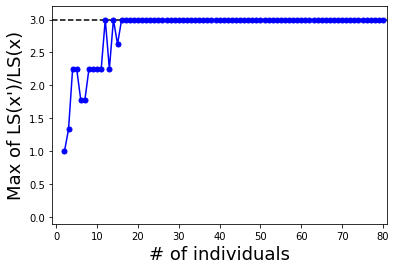

In [6]:
maxR = np.zeros(79); index = np.zeros(79)

for i in range(79):
    maxR[i] = S(i+2)
    index[i] = i+2

fig = plt.figure()
plt.ylim(-0.1, 3.2)
plt.xlim(-1, 81)
plt.hlines(3,-1,81,color="black", linestyle = "dashed")
plt.plot(index, maxR, marker="o", markersize=5, color = "blue", linestyle = "-")
plt.xlabel("# of individuals", fontsize = 18)
plt.ylabel("Max of LS(x')/LS(x)", fontsize = 18)
fig.savefig("goodBeta_3*2.png")
fig.savefig("figs/goodBeta_3*2.eps", bbox_inches="tight", pad_inches=0.05)